In [1]:
#! pip install autogluon
#! pip install autogluon.eda
#! pip install -U pandas

In [2]:
import os
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import (train_test_split, KFold, cross_val_score, 
GridSearchCV, StratifiedKFold)
import numpy as np

# Importar Datos

In [13]:
if os.path.isfile('loans_sampe_data.parquet'):
    loans = pd.read_parquet('loans_sampe_data.parquet')
else:
    print('Descargando Datos')
    loans = pd.read_parquet('https://github.com/sonder-art/automl_o23/raw/main/codigo/intro_ml/loans_sampe_data.parquet')
    loans.to_parquet('loans_sampe_data.parquet')

# Separar los datos (train y test)

Las librerias de AutoML (y practicamente cualquier otra) son incapaces de separar los datos de manera correcta en Train y Test, pues es facil que se equivoquen. Nosotres tenemos que separarlos en train y test (y en validacion si es que se va a utilizar).  

Tambien tenemos que asegurarnos que no exista `leakage`, osea variables que no vamos a tener al momento de aplicar el modelo. Tenemos que proponer un modelo que utilice unicamente las variables que vamos a utilizar en la realidad.  

Tambien tenemos que asegurarnos que nuestro modelo sea util, esto incluye dieseno, entrenamiento, implementacion y uso

In [14]:
loans['loan_status'].value_counts(dropna=False)

Fully Paid            69982
Charged Off           16156
Current               12726
Late (31-120 days)      730
In Grace Period         264
Late (16-30 days)       139
Default                   3
Name: loan_status, dtype: int64

In [15]:
loans = loans.loc[loans['loan_status'].isin(['Fully Paid', 
                                                   'Charged Off'])]
loans['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.812441
Charged Off    0.187559
Name: loan_status, dtype: float64

In [17]:
loans['charged_off'] = (loans['loan_status'] == 'Charged Off').apply(np.uint8)
loans.drop('loan_status', axis=1, inplace=True)
loans['charged_off'].unique()

array([0, 1], dtype=uint8)

In [18]:
loans['charged_off'].value_counts(normalize=True, dropna=False)

0    0.812441
1    0.187559
Name: charged_off, dtype: float64

Recuerda que nuestros datos estan desbalanceados, por lo tanto tenemos que dividir el `train` y el `test` tomando en cuenta esto (estratificacion)

In [21]:
for col in loans.columns:
    print(col, loans[col].nunique())


Unnamed: 0 86138
id 86138
member_id 0
loan_amnt 1216
funded_amnt 1216
funded_amnt_inv 1271
term 2
int_rate 58
installment 17358
grade 7
sub_grade 35
emp_title 32987
emp_length 11
home_ownership 4
annual_inc 7793
verification_status 3
issue_d 5
pymnt_plan 1
desc 4
purpose 13
title 20
zip_code 846
addr_state 46
dti 3975
delinq_2yrs 22
earliest_cr_line 598
fico_range_low 38
fico_range_high 38
inq_last_6mths 7
mths_since_last_delinq 107
mths_since_last_record 121
open_acc 58
pub_rec 17
revol_bal 34677
revol_util 1108
total_acc 108
initial_list_status 2
out_prncp 1
out_prncp_inv 1
total_pymnt 83671
total_pymnt_inv 78000
total_rec_prncp 16447
total_rec_int 72270
total_rec_late_fee 1564
recoveries 9882
collection_recovery_fee 10034
last_pymnt_d 41
last_pymnt_amnt 63512
next_pymnt_d 0
last_credit_pull_d 41
last_fico_range_high 72
last_fico_range_low 71
collections_12_mths_ex_med 8
mths_since_last_major_derog 145
policy_code 1
application_type 1
annual_inc_joint 0
dti_joint 0
verification_statu

In [19]:
a_train, a_test = train_test_split(loans,
                                         stratify=loans['charged_off'],
                                         test_size=0.2, random_state=453890)

a_train, a_val = train_test_split(a_train,stratify=a_train['charged_off'],
                                         test_size=0.2, random_state=7568)

En nuestro caso, parece que la unica columna por la que deberias estratificar es por `charged_off` que es el label. Sin embargo, en otros proyectos puede que necesitemos hacer estratificaciones mas complejas, por ejemplo si hay subgrupos.  

Si en este proyecto pudieramos ver las edades o alguna otra variable importante, convendria tambien estratificar por ellas. Si fueran variables geograficas, tambien o temporales tambien tendriamos que tomarlas encuenta.

In [9]:
print(a_train.head(1))
a_train['charged_off'].value_counts(normalize=True, dropna=False)

       Unnamed: 0        id  member_id  loan_amnt  funded_amnt  \
76544       76544  26229999        NaN    16000.0      16000.0   

       funded_amnt_inv        term  int_rate  installment grade  ...  \
76544          16000.0   36 months     16.99       570.37     D  ...   

      hardship_last_payment_amount disbursement_method debt_settlement_flag  \
76544                          NaN                Cash                    N   

      debt_settlement_flag_date  settlement_status settlement_date  \
76544                      None               None            None   

      settlement_amount settlement_percentage settlement_term charged_off  
76544               NaN                   NaN             NaN           0  

[1 rows x 151 columns]


charged_off
0    0.812437
1    0.187563
Name: proportion, dtype: float64

In [10]:
print(a_val.head(1))
a_val['charged_off'].value_counts(normalize=True, dropna=False)

       Unnamed: 0        id  member_id  loan_amnt  funded_amnt  \
49240       49240  31316533        NaN     9000.0       9000.0   

       funded_amnt_inv        term  int_rate  installment grade  ...  \
49240           9000.0   36 months     13.35       304.77     C  ...   

      hardship_last_payment_amount disbursement_method debt_settlement_flag  \
49240                          NaN                Cash                    N   

      debt_settlement_flag_date  settlement_status settlement_date  \
49240                      None               None            None   

      settlement_amount settlement_percentage settlement_term charged_off  
49240               NaN                   NaN             NaN           0  

[1 rows x 151 columns]


charged_off
0    0.812437
1    0.187563
Name: proportion, dtype: float64

In [11]:
print(a_test.head(1))
a_test['charged_off'].value_counts(normalize=True, dropna=False)

       Unnamed: 0        id  member_id  loan_amnt  funded_amnt  \
92063       92063  24705541        NaN    10000.0      10000.0   

       funded_amnt_inv        term  int_rate  installment grade  ...  \
92063          10000.0   36 months     11.67       330.57     B  ...   

      hardship_last_payment_amount disbursement_method debt_settlement_flag  \
92063                          NaN                Cash                    N   

      debt_settlement_flag_date  settlement_status settlement_date  \
92063                      None               None            None   

      settlement_amount settlement_percentage settlement_term charged_off  
92063               NaN                   NaN             NaN           0  

[1 rows x 151 columns]


charged_off
0    0.812456
1    0.187544
Name: proportion, dtype: float64

# Autogluon

Autogluon puede inferir el tipo de dato, pero se equivoca. Por ejemplo puee pensar que una columna categorica es numerica o viceversa, por lo tanto es conveniente indicarle que tipo de columna es cada cosa de manera explicita.

[Documentacion de Autogluon](https://auto.gluon.ai/)

## Autogluon EDA

Para realizar el EDA autogluon tiene una libreria llamada `autogluon.eda` que viene seaprada de la libreria normal. [Documentacion de Autogluon EDA](https://auto.gluon.ai/stable/tutorials/eda/index.html)

Esta libreria nos ayuda a realizar analisis exploratoria y a asegurarnos que nuestros datos tengan sentido estadistico. Aunque le faltan muchas cosas, y aun requiere de mucho feedback de nuestra parte.

In [23]:
import autogluon.eda.auto as auto


In [24]:
all_train = pd.concat([a_train,a_val], ignore_index=True).copy()
all_train

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,charged_off
0,76544,26229999,NaN,16000.0,16000.0,16000.0,36 months,16.99,570.37,D,...,NaN,Cash,N,None,None,None,NaN,NaN,NaN,0
1,65048,28893716,NaN,8000.0,8000.0,8000.0,36 months,9.17,255.04,B,...,NaN,Cash,N,None,None,None,NaN,NaN,NaN,0
2,71420,28382451,NaN,28775.0,28775.0,28775.0,36 months,14.49,990.33,C,...,NaN,Cash,N,None,None,None,NaN,NaN,NaN,0
3,32390,33251700,NaN,20000.0,20000.0,20000.0,36 months,12.99,673.79,C,...,NaN,Cash,N,None,None,None,NaN,NaN,NaN,0
4,84410,26087809,NaN,15000.0,15000.0,15000.0,36 months,9.17,478.19,B,...,NaN,Cash,N,None,None,None,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68905,38250,32399529,NaN,15000.0,15000.0,15000.0,60 months,14.49,352.85,C,...,NaN,Cash,N,None,None,None,NaN,NaN,NaN,0
68906,74036,27642003,NaN,1400.0,1400.0,1400.0,36 months,15.61,48.96,D,...,NaN,Cash,N,None,None,None,NaN,NaN,NaN,0
68907,12956,35713975,NaN,28000.0,28000.0,28000.0,60 months,11.99,622.71,B,...,NaN,Cash,N,None,None,None,NaN,NaN,NaN,0
68908,84729,26067703,NaN,10000.0,10000.0,9900.0,36 months,10.15,323.38,B,...,NaN,Cash,N,None,None,None,NaN,NaN,NaN,0


### Missing Values

### Missing Values Analysis

,missing_count,missing_ratio
member_id,10000,1.0000
emp_title,555,0.0555
emp_length,555,0.0555
desc,10000,1.0000
mths_since_last_delinq,4902,0.4902
mths_since_last_record,8281,0.8281
revol_util,5,0.0005
last_pymnt_d,8,0.0008
next_pymnt_d,10000,1.0000
last_credit_pull_d,2,0.0002


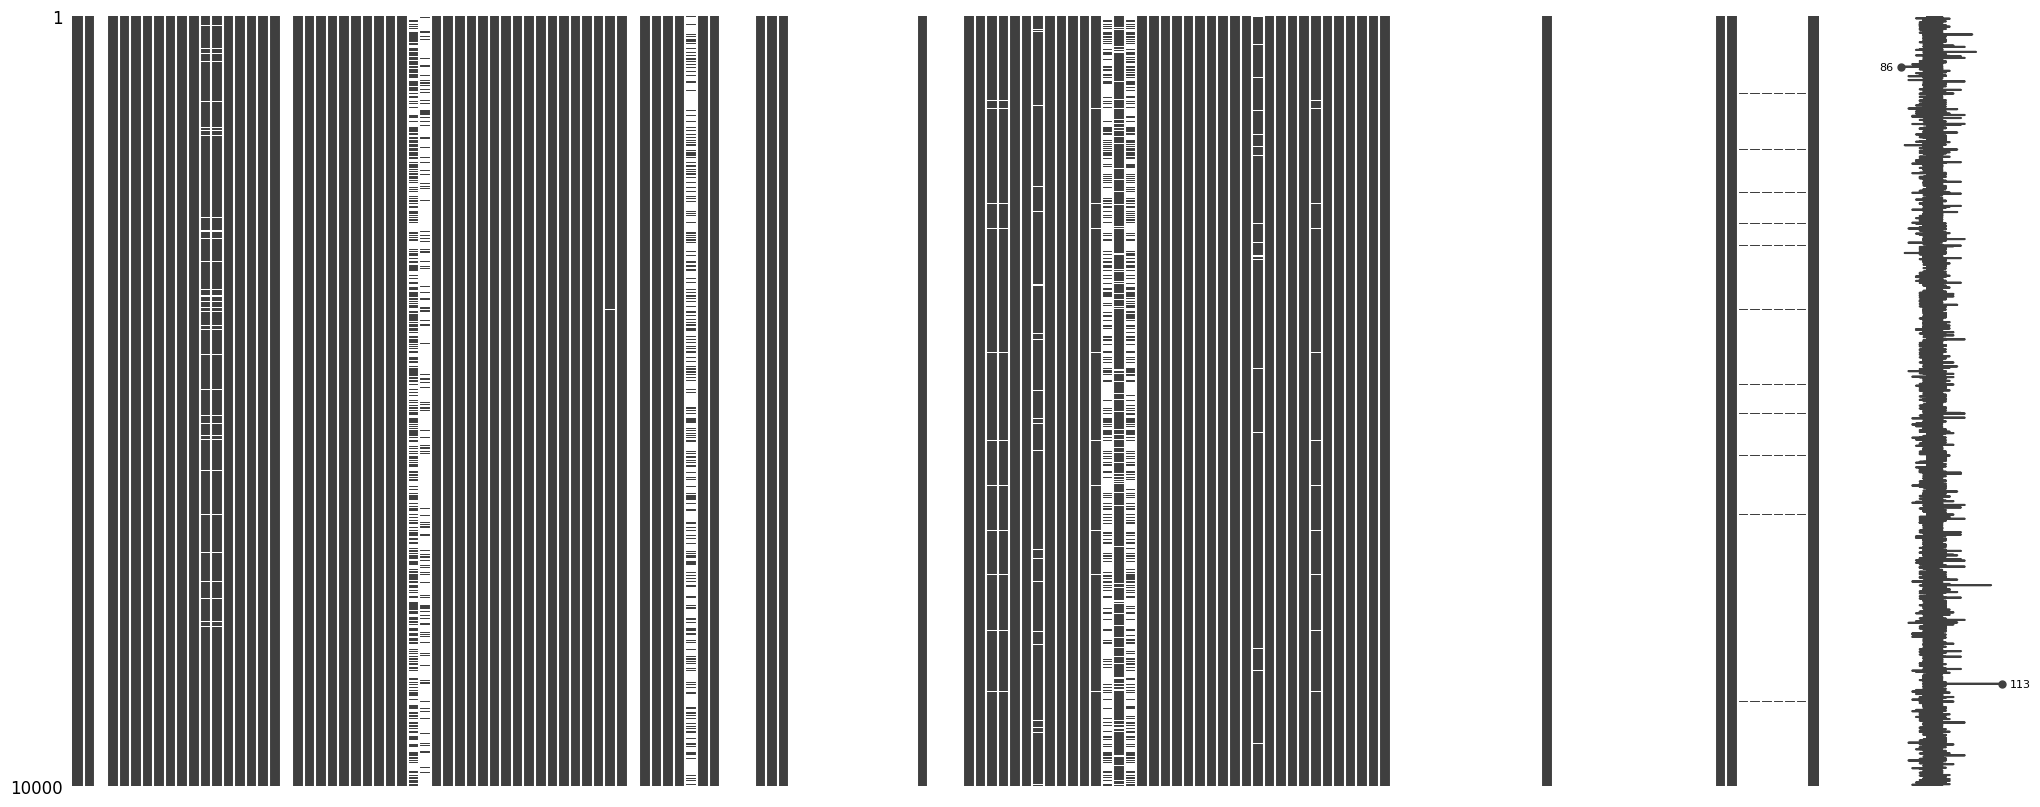

In [14]:
missings = auto.missing_values_analysis(train_data=all_train)

In [15]:
# Define the threshold (in this case, 90% or 0.9)
threshold = 90

# Get the columns that have a null percentage greater than the threshold
null_percentage = (all_train.isnull().sum() / len(all_train)) * 100
columns_to_drop = null_percentage[null_percentage > threshold].index
print(columns_to_drop)
# Drop the columns
a_train.drop(columns=columns_to_drop, inplace=True)
a_test.drop(columns=columns_to_drop, inplace=True)
a_val.drop(columns=columns_to_drop, inplace=True)
all_train.drop(columns=columns_to_drop, inplace=True)

Index(['member_id', 'desc', 'next_pymnt_d', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'open_acc_6m', 'open_act_il',
       'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il',
       'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'inq_fi', 'total_cu_tl', 'inq_last_12m', 'revol_bal_joint',
       'sec_app_fico_range_low', 'sec_app_fico_range_high',
       'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util',
       'sec_app_open_act_il', 'sec_app_num_rev_accts',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med',
       'sec_app_mths_since_last_major_derog', 'hardship_type',
       'hardship_reason', 'hardship_status', 'deferral_term',
       'hardship_amount', 'hardship_start_date', 'hardship_end_date',
       'payment_plan_start_date', 'hardship_length', 'hardship_dpd',
       'hardship_loan_status', 'orig_project

**`train_data` dataset summary (sample size: 10000)**

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtypes,missing_count,missing_ratio,raw_type,variable_type,special_types
Unnamed: 0,10000,10000,,,50464.4835,28923.297905,1.0,25648.0,50357.5,75645.0,99995.0,int64,,,int,numeric,
acc_now_delinq,10000,3,,,0.0057,0.082875,0.0,0.0,0.0,0.0,2.0,float64,,,float,category,
acc_open_past_24mths,10000,26,,,4.6013,3.070941,0.0,2.0,4.0,6.0,42.0,float64,,,float,numeric,
addr_state,10000,46,CA,1437,,,,,,,,object,,,object,category,
annual_inc,10000,1443,,,73178.239042,47513.272586,4000.0,45000.0,62000.0,89000.0,900000.0,float64,,,float,numeric,
application_type,10000,1,Individual,10000,,,,,,,,object,,,object,category,
avg_cur_bal,10000,8039,,,13042.8875,15995.720627,0.0,2942.75,6934.0,18039.5,447433.0,float64,,,float,numeric,
bc_open_to_buy,9888,6859,,,8775.811792,14078.576055,0.0,1089.75,3739.5,10335.75,224525.0,float64,112,0.0112,float,numeric,
bc_util,9882,1048,,,63.870806,27.154072,0.0,44.1,68.15,87.4,141.2,float64,118,0.0118,float,numeric,
charged_off,10000,2,,,0.183,0.386686,0.0,0.0,0.0,0.0,1.0,uint8,,,int,category,


**`test_data` dataset summary (sample size: 10000)**

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtypes,missing_count,missing_ratio,raw_type,variable_type,special_types
Unnamed: 0,10000,10000,,,50479.9819,28903.488769,12.0,25489.75,50174.5,75792.5,99999.0,int64,,,int,numeric,
acc_now_delinq,10000,5,,,0.0071,0.098237,0.0,0.0,0.0,0.0,4.0,float64,,,float,category,
acc_open_past_24mths,10000,27,,,4.5811,3.058195,0.0,2.0,4.0,6.0,39.0,float64,,,float,numeric,
addr_state,10000,46,CA,1471,,,,,,,,object,,,object,category,
annual_inc,10000,1429,,,73930.624622,52583.752854,6900.0,45000.0,62000.0,89000.0,1250000.0,float64,,,float,numeric,
application_type,10000,1,Individual,10000,,,,,,,,object,,,object,category,
avg_cur_bal,10000,8044,,,13374.1735,17152.44231,0.0,2991.0,6978.5,18252.25,278317.0,float64,,,float,numeric,
bc_open_to_buy,9883,6893,,,8916.250936,13863.52323,0.0,1089.0,3775.0,10620.0,225313.0,float64,117,0.0117,float,numeric,
bc_util,9878,1060,,,63.712533,27.051444,0.0,43.9,67.6,87.5,188.8,float64,122,0.0122,float,numeric,
charged_off,10000,2,,,0.189,0.391528,0.0,0.0,0.0,0.0,1.0,uint8,,,int,category,


### Feature Distance

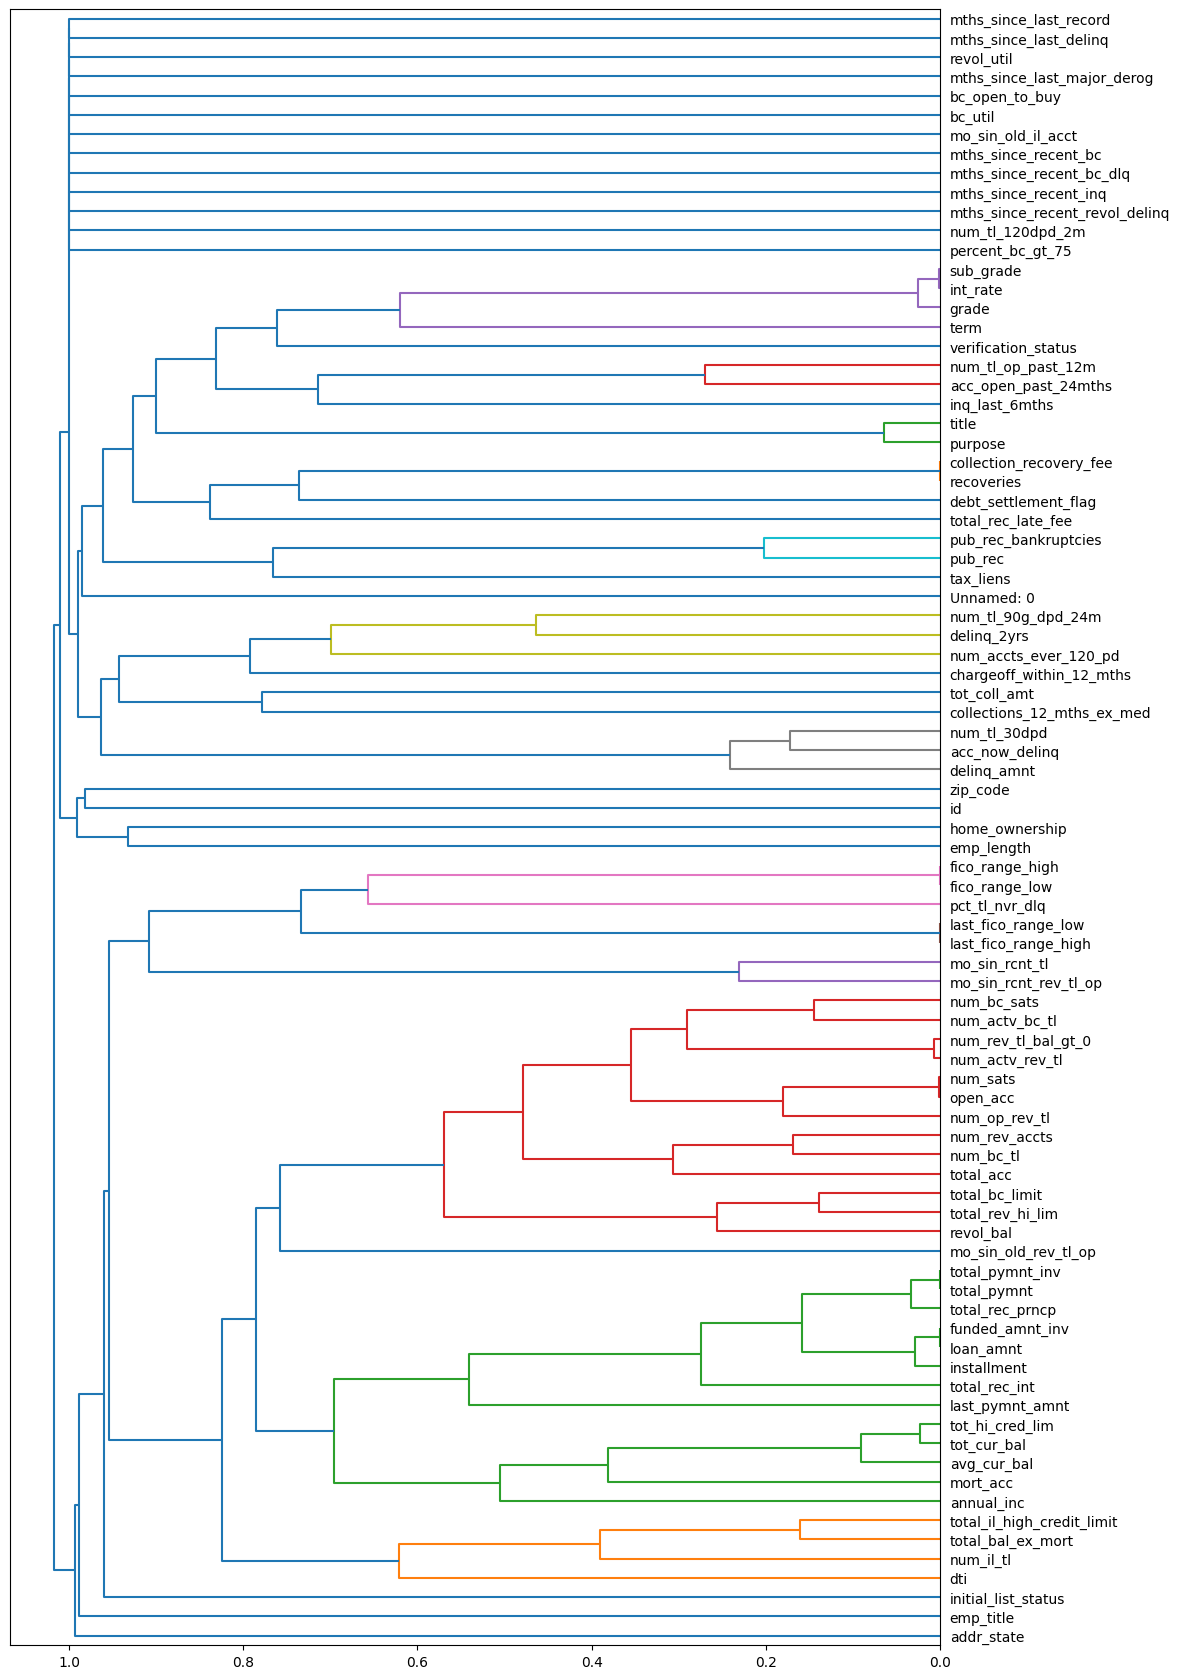

**The following feature groups are considered as near-duplicates**:

Distance threshold: <= `0.01`. Consider keeping only some of the columns within each group:

 - `total_pymnt`, `total_pymnt_inv` - distance `0.00`
 - `fico_range_high`, `fico_range_low` - distance `0.00`
 - `last_fico_range_high`, `last_fico_range_low` - distance `0.00`
 - `funded_amnt_inv`, `loan_amnt` - distance `0.00`
 - `collection_recovery_fee`, `recoveries` - distance `0.00`
 - `num_sats`, `open_acc` - distance `0.00`
 - `int_rate`, `sub_grade` - distance `0.00`
 - `num_actv_rev_tl`, `num_rev_tl_bal_gt_0` - distance `0.01`

Feature interaction between `total_pymnt`/`total_pymnt_inv`

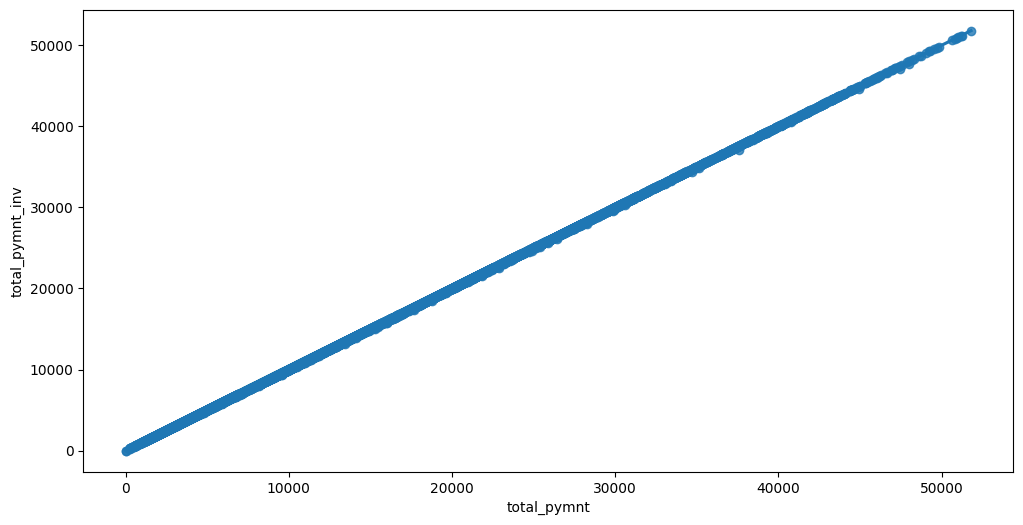

Feature interaction between `fico_range_high`/`fico_range_low`

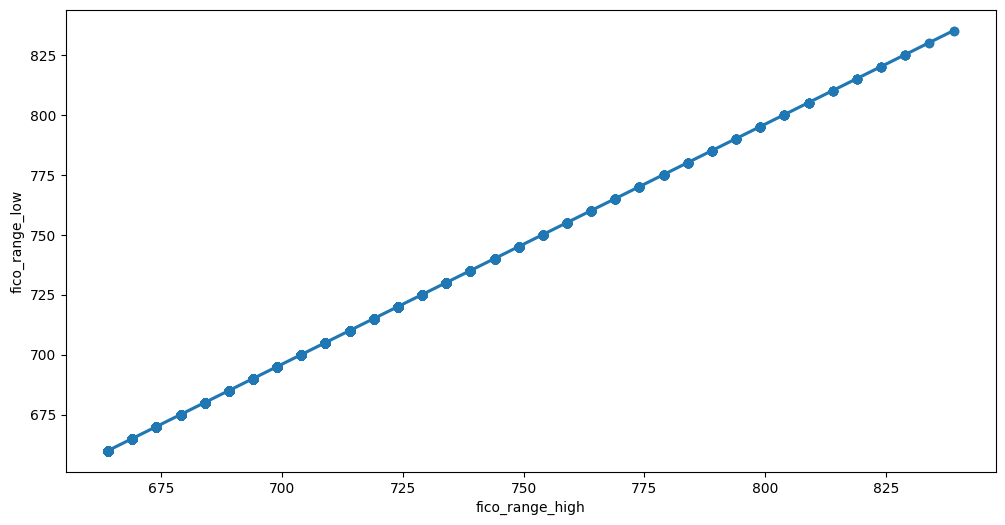

Feature interaction between `last_fico_range_high`/`last_fico_range_low`

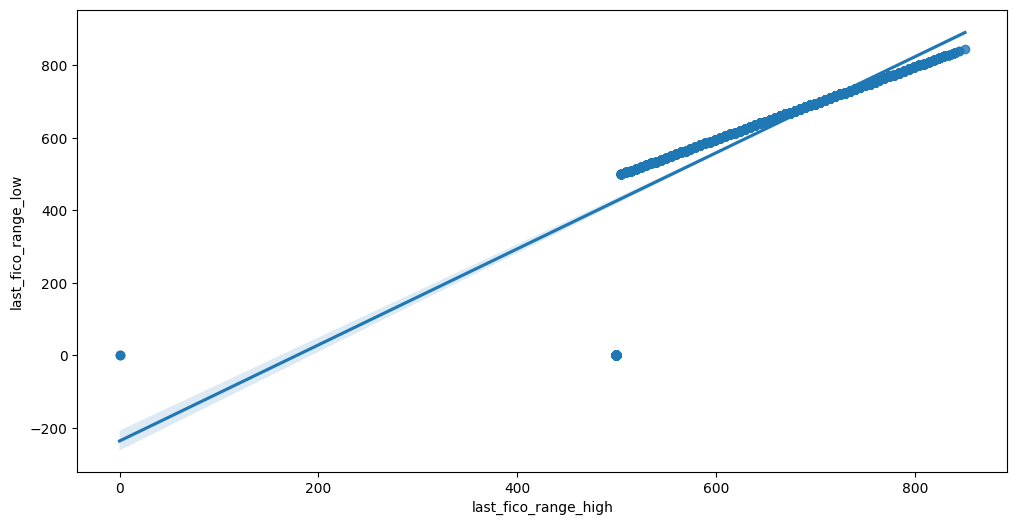

Feature interaction between `funded_amnt_inv`/`loan_amnt`

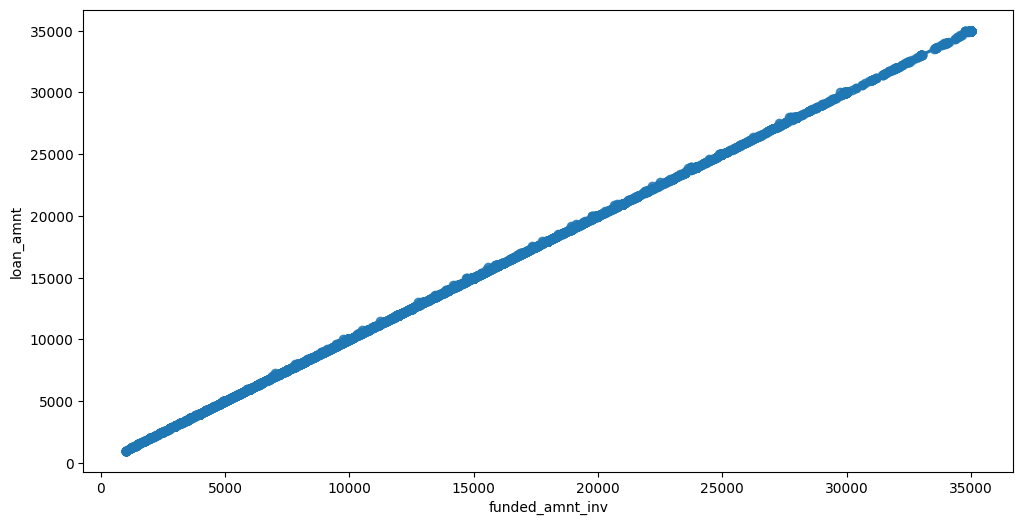

Feature interaction between `collection_recovery_fee`/`recoveries`

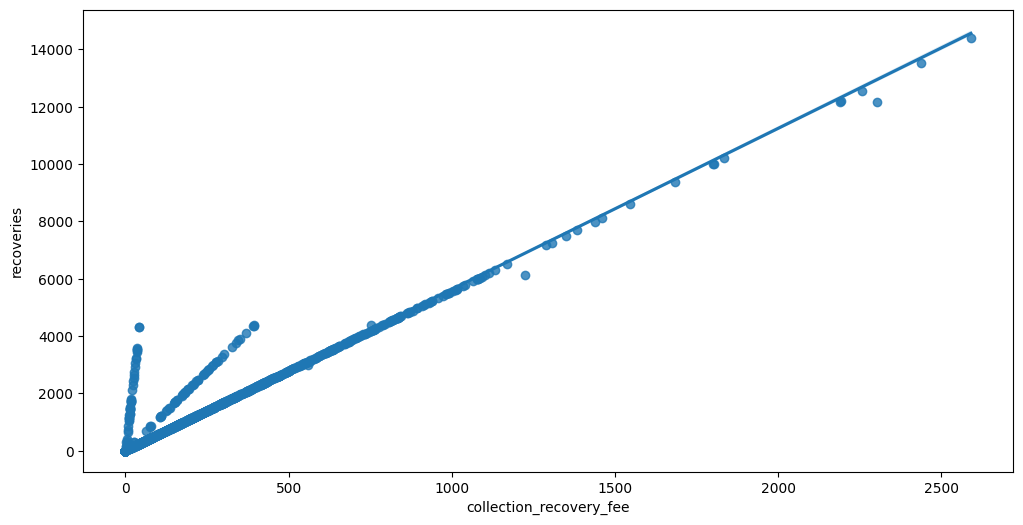

Feature interaction between `num_sats`/`open_acc`

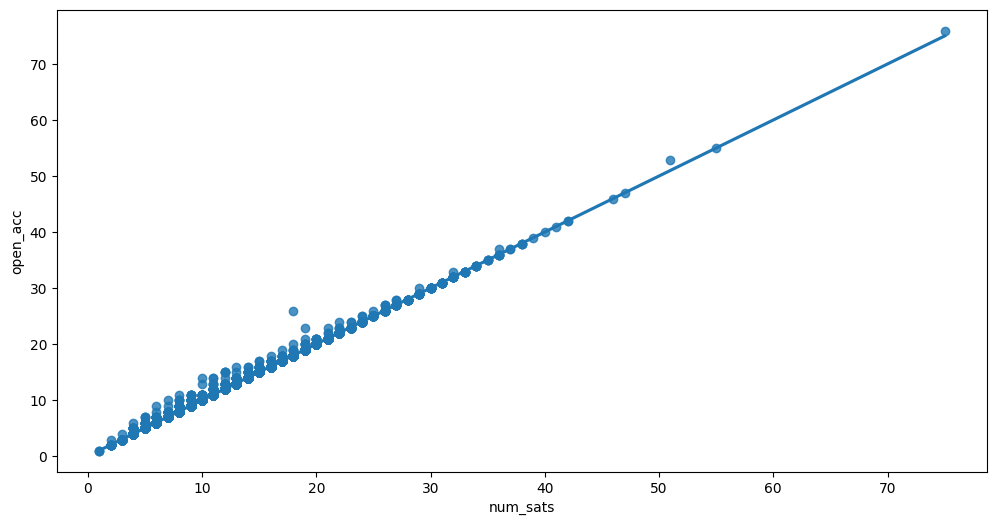

Feature interaction between `num_actv_rev_tl`/`num_rev_tl_bal_gt_0`

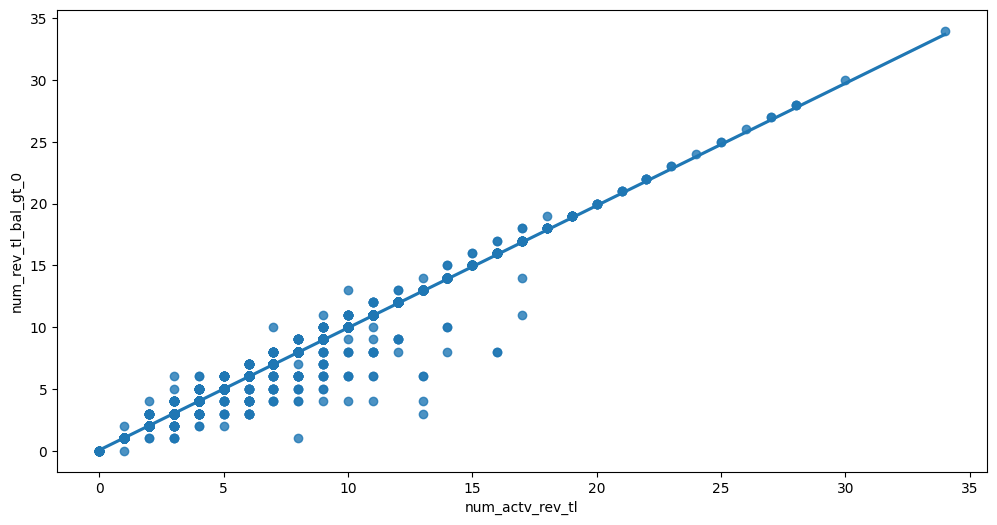

In [16]:
eda_overview = auto.dataset_overview(train_data=all_train, test_data=a_test, 
                      label='charged_off')

In [17]:
remove_columns_correlated = [
'total_pymnt', #total_pymnt_inv - distance 0.00
'debt_settlement_flag', #settlement_status - distance 0.00
'fico_range_high', #fico_range_low - distance 0.00
'last_fico_range_high', #last_fico_range_low - distance 0.00
'funded_amnt_inv', #loan_amnt - distance 0.00
'collection_recovery_fee', #recoveries - distance 0.00
'num_sats', #open_acc - distance 0.00
'int_rate', #sub_grade - distance 0.00
'num_actv_rev_tl',# num_rev_tl_bal_gt_0 
]

In [18]:
a_train = a_train.drop(columns=remove_columns_correlated)
a_val = a_val.drop(columns=remove_columns_correlated)
a_test = a_test.drop(columns=remove_columns_correlated)
all_train = all_train.drop(columns=remove_columns_correlated)


### Target EDA

## Target variable analysis

### Label Insights

 - Mild minority class imbalance detected - imbalance ratio is `22.40%`. Recommendations:
   - downsample majority class `0` to improve the balance
   - upweight downsampled class so that `sample_weight = original_weight x downsampling_factor`.[TabularPredictor](https://auto.gluon.ai/stable/api/autogluon.predictor.html#module-0) supports this via `sample_weight` parameter

,count,mean,std,min,25%,50%,75%,max,dtypes,unique,missing_count,missing_ratio,raw_type,special_types
charged_off,10000,0.183,0.386686,0.0,0.0,0.0,0.0,1.0,uint8,2,,,int,


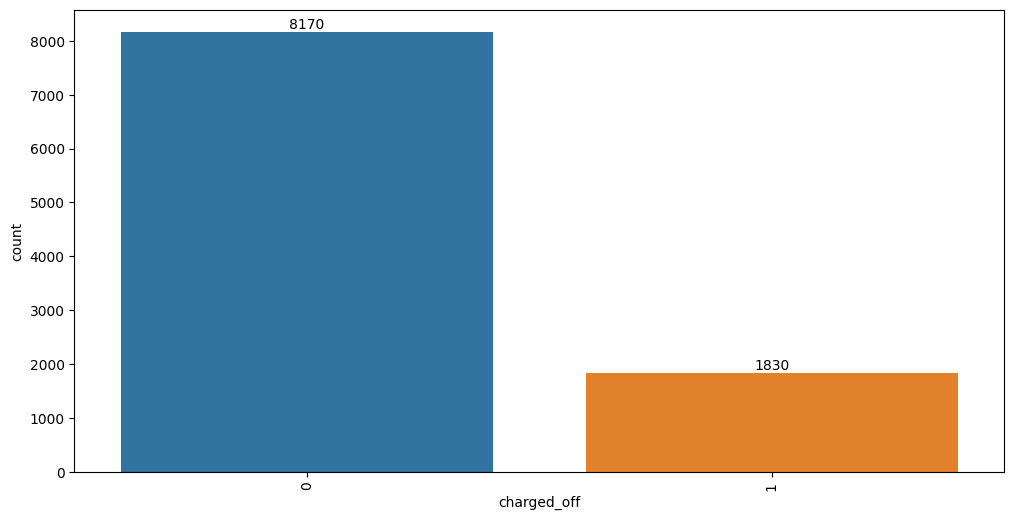

### Target variable correlations

**`train_data` - `spearman` correlation matrix; focus: absolute correlation for `charged_off` >= `0.5` (sample size: 10000)**

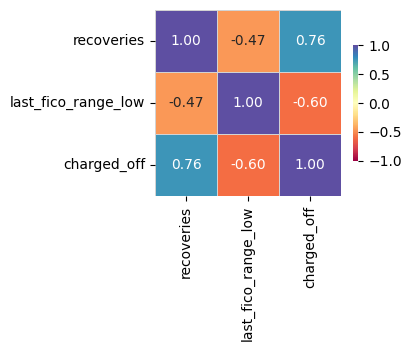

**Feature interaction between `recoveries`/`charged_off` in `train_data` (sample size: 10000)**

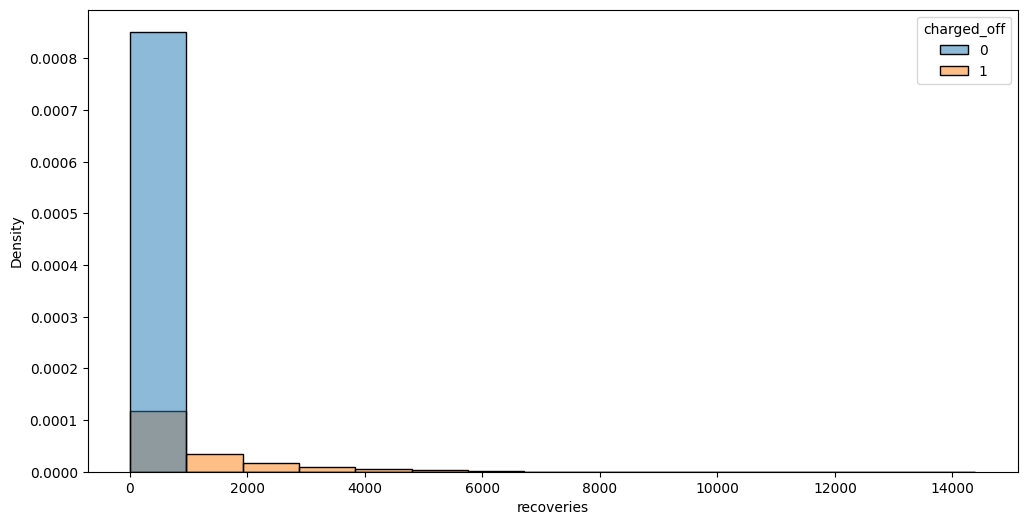

**Feature interaction between `last_fico_range_low`/`charged_off` in `train_data` (sample size: 10000)**

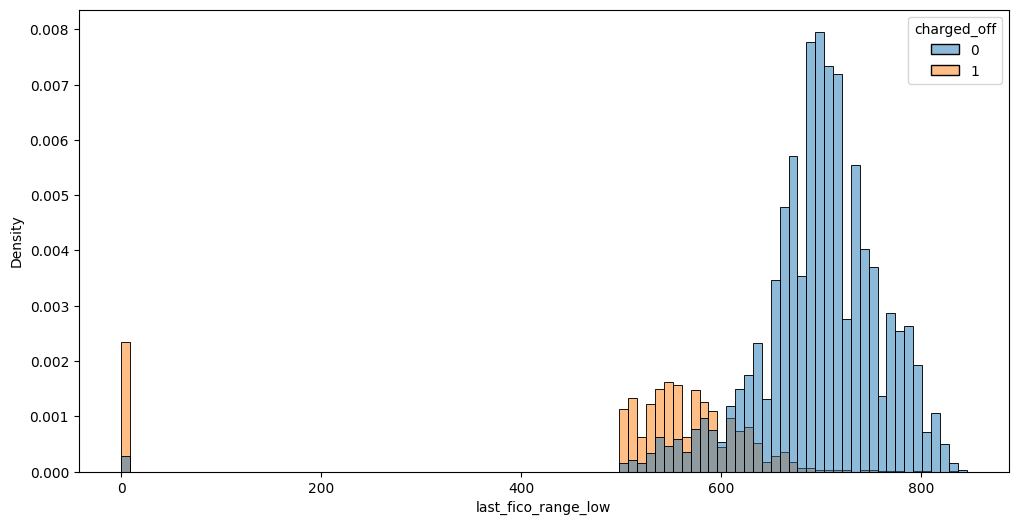

In [19]:
auto.target_analysis(train_data=all_train, label='charged_off')

### Covarianza entre X's

In [20]:
auto.covariate_shift_detection(train_data=all_train, test_data=a_test, label='charged_off')

We did not detect a substantial difference between the training and test X distributions.

In [21]:
auto.covariate_shift_detection(train_data=a_train, test_data=a_val, label='charged_off')

We did not detect a substantial difference between the training and test X distributions.

### Simple Model

No path specified. Models will be saved in: "AutogluonModels/ag-20230927_193217/"


### Model Prediction for charged_off

Using validation data for `Test` points

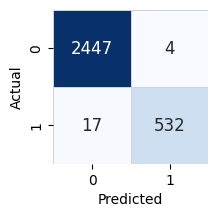

### Model Leaderboard

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT,0.993,0.997143,0.014691,0.014515,1.022758,0.014691,0.014515,1.022758,1,True,1


### Feature Importance for Trained Model

,importance,stddev,p_value,n,p99_high,p99_low
recoveries,0.057933,0.001479,5.099611e-08,5,0.060980,0.054887
last_pymnt_amnt,0.054600,0.001479,6.462984e-08,5,0.057646,0.051554
last_fico_range_low,0.041467,0.003525,6.203139e-06,5,0.048724,0.034210
last_pymnt_d,0.025067,0.001188,6.034176e-07,5,0.027513,0.022621
total_rec_prncp,0.015067,0.001479,1.101531e-05,5,0.018113,0.012020
term,0.009733,0.001362,4.485651e-05,5,0.012538,0.006929
installment,0.003067,0.000723,3.441407e-04,5,0.004555,0.001579
loan_amnt,0.002800,0.001261,3.833847e-03,5,0.005395,0.000205
total_rec_int,0.001067,0.000435,2.685221e-03,5,0.001962,0.000172
last_credit_pull_d,0.000933,0.000494,6.732538e-03,5,0.001951,-0.000085


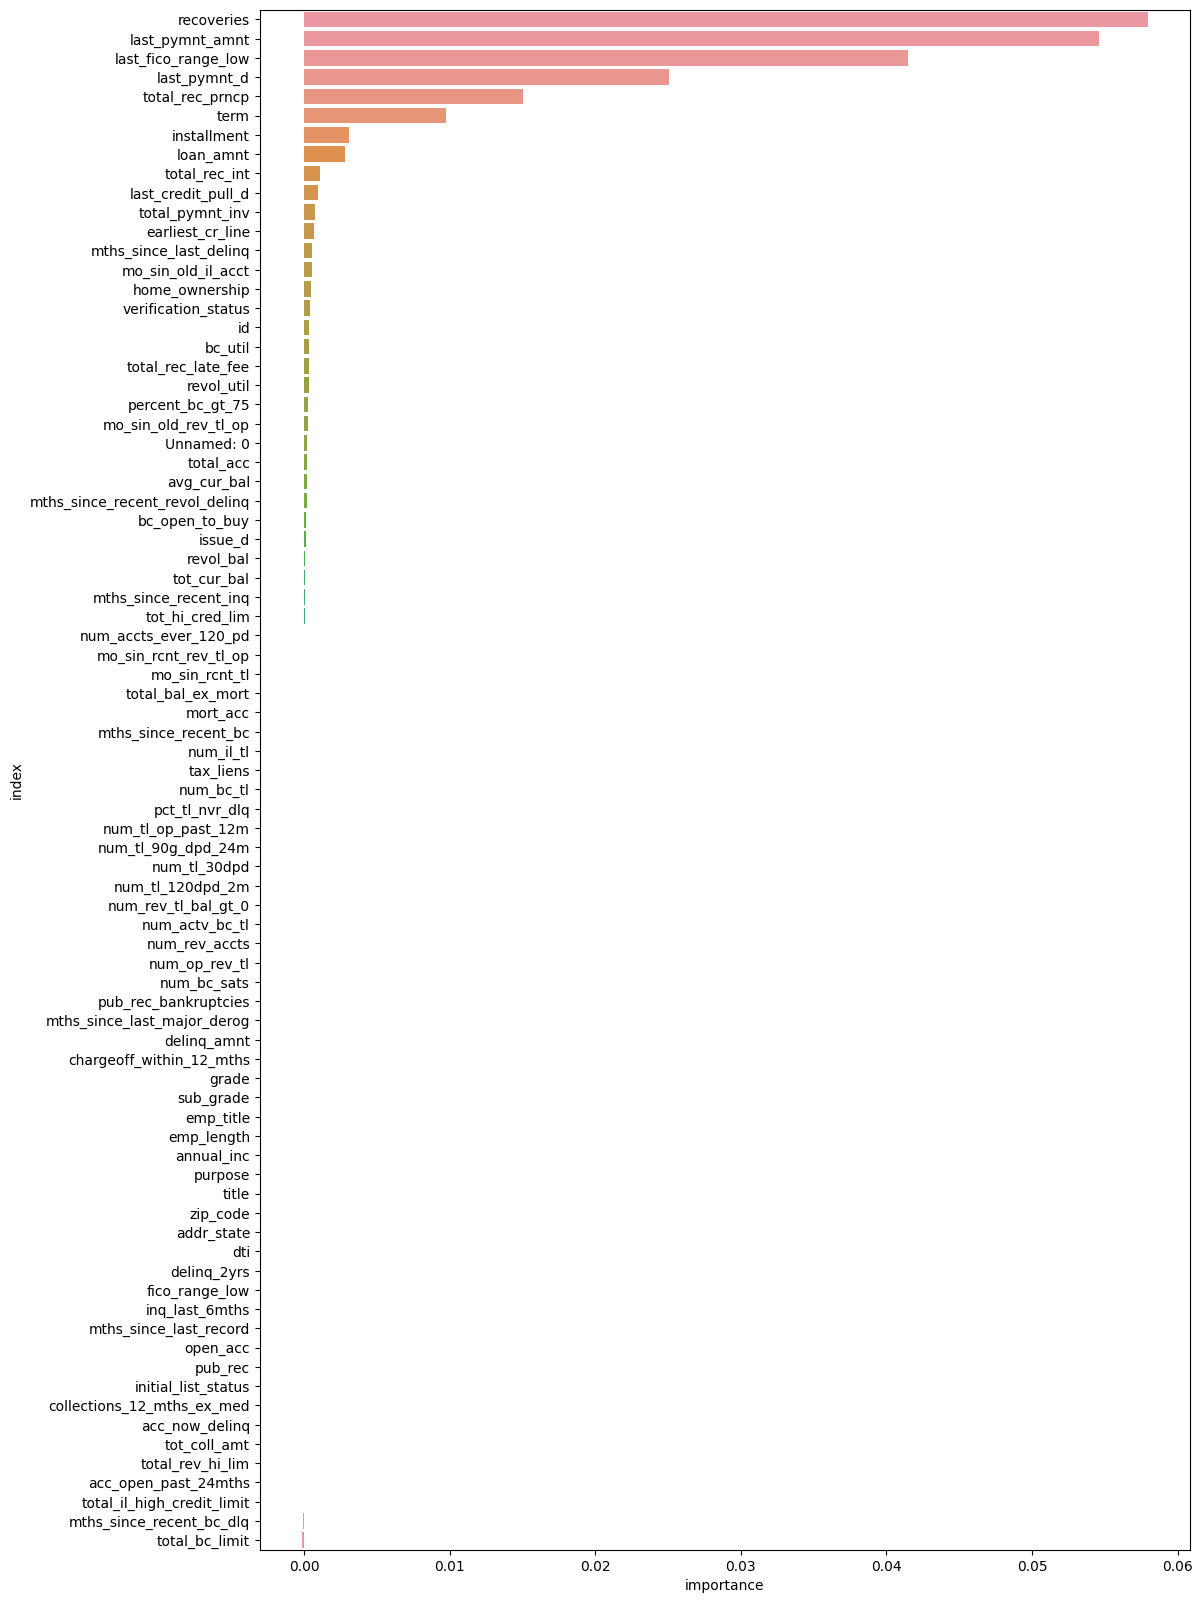

### Rows with the highest prediction error

Rows in this category worth inspecting for the causes of the error

,Unnamed: 0,id,loan_amnt,funded_amnt,term,installment,grade,sub_grade,emp_title,emp_length,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,charged_off,0,1,error
25421,23804,34722813,10000.0,10000.0,36 months,340.13,C,C3,administrative assistant,3 years,...,23425.0,14364.0,9900.0,6500.0,N,Cash,1,0.939358,0.060642,0.878716
68256,50892,30996120,8650.0,8650.0,36 months,308.36,D,D3,Manager,10+ years,...,474708.0,18763.0,2200.0,21708.0,N,Cash,1,0.873036,0.126964,0.746072
59403,29058,34392060,30000.0,30000.0,60 months,658.88,B,B4,Manager Managed Care Contracting,10+ years,...,219171.0,34739.0,20900.0,35801.0,N,Cash,1,0.870023,0.129977,0.740046
38733,80439,26260391,9225.0,9225.0,36 months,322.56,D,D1,None,None,...,151900.0,13665.0,49600.0,0.0,N,Cash,1,0.866473,0.133527,0.732946
14245,60135,29664395,25000.0,25000.0,36 months,779.84,A,A4,System Engineer,4 years,...,100554.0,38489.0,64700.0,23663.0,N,Cash,1,0.820950,0.179050,0.641900
22632,51941,30756075,9600.0,9600.0,36 months,306.04,B,B1,Account Representative,10+ years,...,51188.0,29539.0,5800.0,25688.0,N,Cash,1,0.740296,0.259704,0.480592
2838,94757,24144490,14000.0,14000.0,60 months,325.62,C,C3,None,None,...,352333.0,33990.0,5000.0,35260.0,N,Cash,1,0.727026,0.272974,0.454052
8221,9674,35979558,10000.0,10000.0,60 months,234.30,C,C4,Senior Office Assistant,2 years,...,96077.0,83498.0,35200.0,53277.0,N,Cash,1,0.662518,0.337482,0.325037
35237,62284,29254321,9000.0,9000.0,36 months,309.75,C,C4,sales associate,1 year,...,9110.0,6787.0,4400.0,3010.0,N,Cash,1,0.650934,0.349066,0.301868
61886,44670,31537866,10500.0,10500.0,36 months,351.22,B,B5,None,None,...,24536.0,16709.0,3000.0,19036.0,N,Cash,1,0.645110,0.354889,0.290221


### Rows with the least distance vs other class

Rows in this category are the closest to the decision boundary vs the other class and are good candidates for additional labeling

,Unnamed: 0,id,loan_amnt,funded_amnt,term,installment,grade,sub_grade,emp_title,emp_length,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,charged_off,0,1,error
53426,21889,34593341,10200.0,10200.0,60 months,254.27,D,D4,Technical Writer,10+ years,...,271683.0,77799.0,4200.0,89466.0,N,Cash,0,0.495228,0.504772,0.009544
28593,16617,35338360,8850.0,8850.0,36 months,322.36,E,E1,None,None,...,119209.0,95698.0,4200.0,115009.0,N,Cash,1,0.534083,0.465917,0.068167
53117,88257,24865158,8000.0,8000.0,36 months,264.46,B,B4,nanny,10+ years,...,35248.0,24083.0,13000.0,16248.0,N,Cash,0,0.457252,0.542748,0.085496
11496,46215,31567205,12600.0,12600.0,36 months,461.81,E,E1,Account Manager,< 1 year,...,235931.0,37840.0,16400.0,31500.0,N,Cash,0,0.443449,0.556551,0.113102
57760,53491,30435685,20000.0,20000.0,60 months,503.21,D,D4,None,None,...,479797.0,119672.0,8800.0,111926.0,N,Cash,0,0.433428,0.566572,0.133145
57405,96281,21100461,18900.0,18900.0,60 months,511.21,E,E4,Manager,8 years,...,51898.0,42164.0,6300.0,43598.0,N,Cash,1,0.568287,0.431713,0.136574
59768,53781,30575483,25000.0,25000.0,36 months,773.30,A,A3,Controller,< 1 year,...,502450.0,36259.0,55400.0,0.0,N,Cash,1,0.589030,0.410970,0.178060
35151,9454,36039615,28000.0,28000.0,36 months,852.20,A,A1,Chief Engineer,< 1 year,...,326625.0,14979.0,67900.0,0.0,N,Cash,1,0.599744,0.400256,0.199487
43412,17195,30335222,35000.0,35000.0,36 months,1238.98,D,D3,Quality Trainer,10+ years,...,94907.0,71599.0,4600.0,88107.0,N,Cash,1,0.607968,0.392032,0.215935
17397,1426,37670606,8975.0,8975.0,36 months,320.61,D,D4,Owner,3 years,...,45051.0,27447.0,4000.0,41051.0,N,Cash,1,0.626585,0.373415,0.253170


In [22]:
state = auto.quick_fit(
    all_train, 
    'charged_off', 
    return_state=True,
    show_feature_importance_barplots=True
)

,Unnamed: 0,id,loan_amnt,funded_amnt,term,installment,grade,sub_grade,emp_title,emp_length,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,charged_off,0,1,error
25421,23804,34722813,10000.0,10000.0,36 months,340.13,C,C3,administrative assistant,3 years,...,23425.0,14364.0,9900.0,6500.0,N,Cash,1,0.939358,0.060642,0.878716


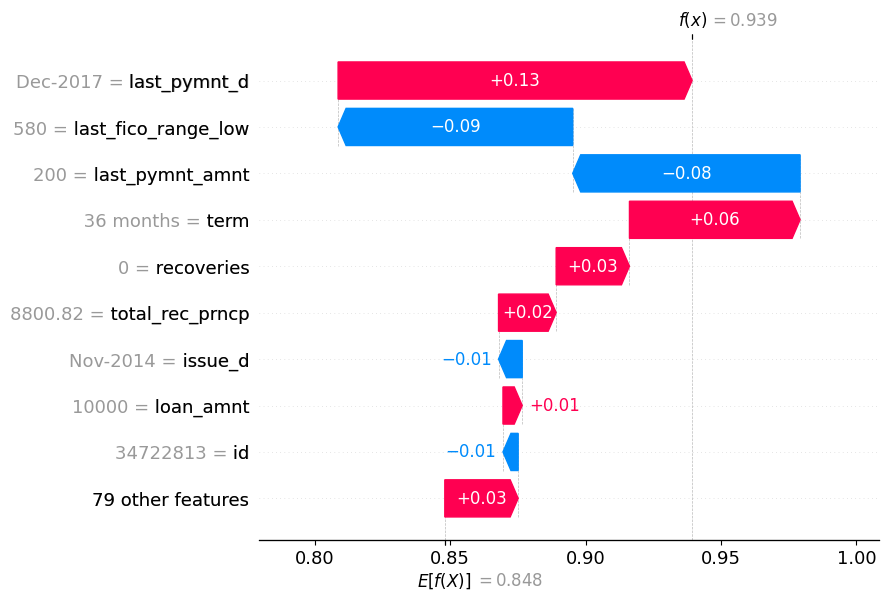

In [23]:
auto.explain_rows(
    train_data=all_train,
    model=state.model,
    display_rows=True,
    plot='waterfall',
    rows=state.model_evaluation.highest_error[:1]
)

## Autogluon Entrenamiento

### Metricas

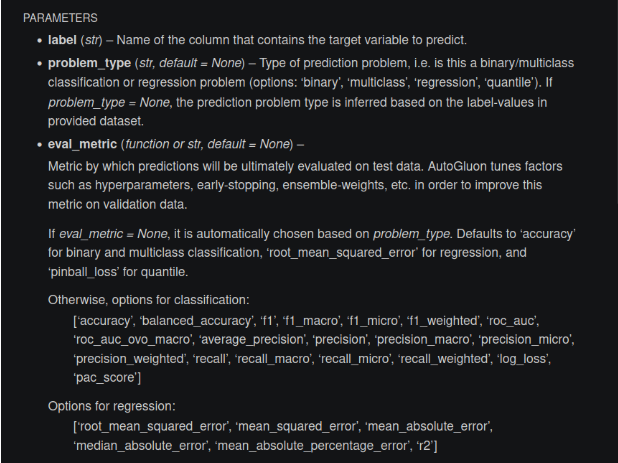

### Pesos

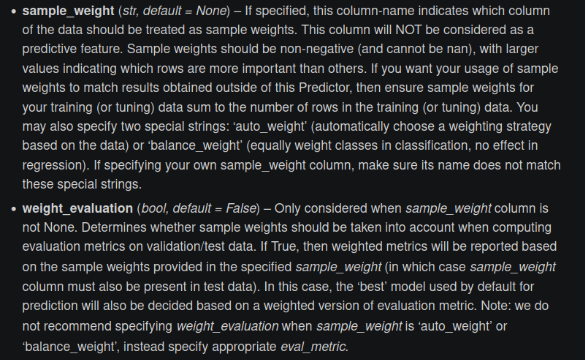

In [24]:
save_path = 'AutogluonModels'


predictor = TabularPredictor(label='charged_off', path=save_path, 
                             problem_type='binary',
                             eval_metric='log_loss', # Es mas rapido de entrenar
                             sample_weight='balance_weight' # Pesos a a la funcion de perdida
                             )

### Fit

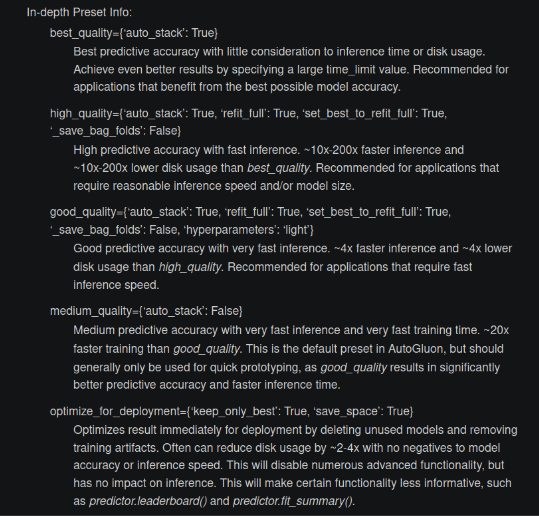

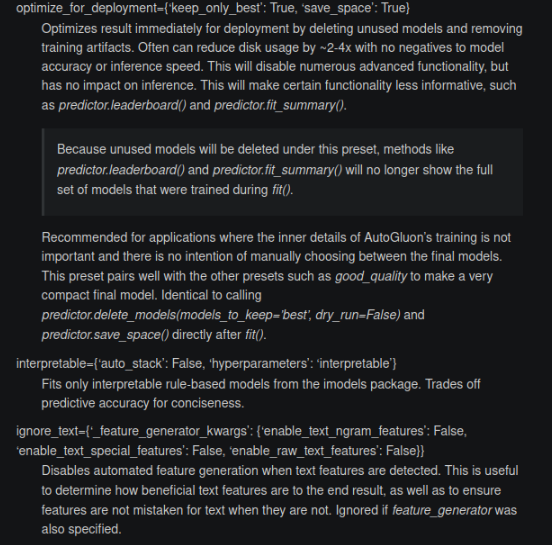

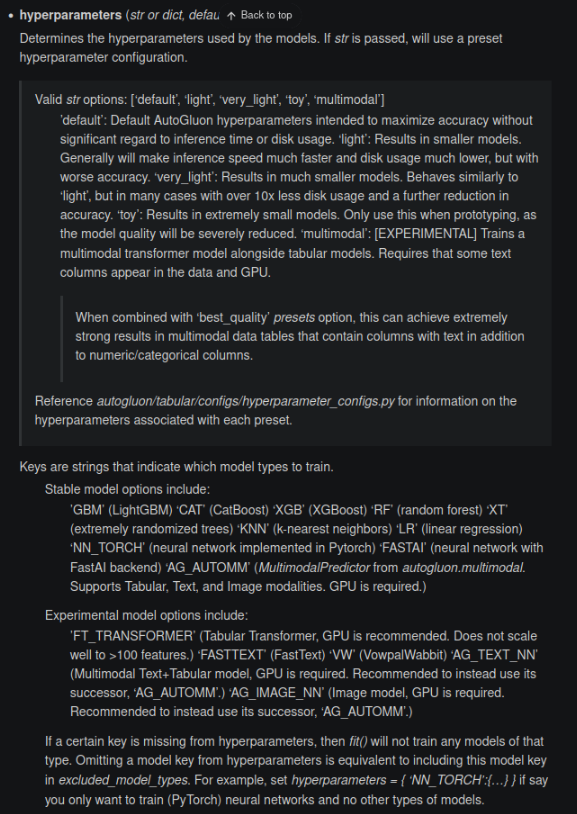

#### Validation

In [25]:
predictor_val = TabularPredictor(label='charged_off', path=os.path.join(save_path,'validation'), 
                             problem_type='binary',
                             eval_metric='log_loss', # Es mas rapido de entrenar, luego evaluamos otras metricas
                             sample_weight='balance_weight', # Pesos a a la funcion de perdida
                             ).fit(
                                 train_data = a_train,
                                 time_limit = None, # Seconds o None para no poner limite
                                 presets='medium_quality',
                                 num_cpus = 8,
                                 tuning_data = a_val,
                                 hyperparameters = {
                                #'NN_TORCH': {},
                                'GBM': [{'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}}, {}, 'GBMLarge'],
                                #'CAT': {},
                                #'XGB': {},
                                #'FASTAI': {},
                                'RF': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}},
                                       {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}},
                                       {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
                                # 'XT': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}},
                                #        {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}, 
                                #        {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
                                'KNN': [{'weights': 'uniform', 'ag_args': {'name_suffix': 'Unif'}},
                                        {'weights': 'distance', 'ag_args': {'name_suffix': 'Dist'}}],
                            }
                             )

Presets specified: ['medium_quality']
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Using predefined sample weighting strategy: balance_weight. Evaluation metrics will ignore sample weights, specify weight_evaluation=True to instead report weighted metrics.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/validation/"
AutoGluon Version:  0.8.2
Python Version:     3.10.9
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT Tue Jul 25 07:08:56 UTC 2023
Disk Space Avail:   135.80 GB / 474.52 GB (28.6%)
Train Data Rows:    55128
Train Data Columns: 88
Tuning Data Rows:    13782
Tuning Data Columns: 88
Label Column: charged_off
Preprocessing data ...


Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Assigning sample weights to balance differences in frequency of classes.
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    25451.18 MB
	Train Data (Original)  Memory Usage: 125.58 MB (0.5% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator

In [ ]:
predictor_val.feature_importance(a_val)

These features in provided data are not utilized by the predictor and will be ignored: ['funded_amnt', 'pymnt_plan', 'out_prncp', 'out_prncp_inv', 'policy_code', 'application_type', 'hardship_flag', 'disbursement_method']
Computing feature importance via permutation shuffling for 80 features using 5000 rows with 5 shuffle sets...


AttributeError: 'NoneType' object has no attribute 'predict'

In [ ]:
predictor_val.leaderboard(a_val, extra_metrics=['mcc', 'balanced_accuracy', 'f1', 'precision', 'roc_auc'])

                 model  score_test       mcc  balanced_accuracy        f1  precision   roc_auc  score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2   -0.003204  0.996666           0.997292  0.997285   1.000000  0.999989  -0.003211        0.539595       0.596376  42.935085                 0.010342                0.000779           0.628697            2       True          8
1             LightGBM   -0.003474  0.997142           0.997679  0.997674   1.000000  0.999990  -0.003474        0.158468       0.222702  12.817834                 0.158468                0.222702          12.817834            1       True          4
2        LightGBMLarge   -0.006175  0.993564           0.995670  0.994762   0.997665  0.999959  -0.006175        0.125957       0.107035  16.066727                 0.125957                0.107035          16.066727            1       True        

,model,score_test,mcc,balanced_accuracy,f1,precision,roc_auc,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.003204,0.996666,0.997292,0.997285,1.000000,0.999989,-0.003211,0.539595,0.596376,42.935085,0.010342,0.000779,0.628697,2,True,8
1,LightGBM,-0.003474,0.997142,0.997679,0.997674,1.000000,0.999990,-0.003474,0.158468,0.222702,12.817834,0.158468,0.222702,12.817834,1,True,4
2,LightGBMLarge,-0.006175,0.993564,0.995670,0.994762,0.997665,0.999959,-0.006175,0.125957,0.107035,16.066727,0.125957,0.107035,16.066727,1,True,7
3,LightGBMXT,-0.007740,0.991656,0.994867,0.993213,0.995723,0.999934,-0.007740,0.244828,0.265860,13.421827,0.244828,0.265860,13.421827,1,True,3
4,RandomForestEntr,-0.031720,0.984485,0.988023,0.987287,0.998418,0.999854,-0.031720,0.177322,0.193435,12.274726,0.177322,0.193435,12.274726,1,True,6
5,RandomForestGini,-0.033125,0.984248,0.987680,0.987084,0.998812,0.999845,-0.033125,0.305217,0.160406,11.682856,0.305217,0.160406,11.682856,1,True,5
6,KNeighborsUnif,-0.808678,0.536093,0.741099,0.606127,0.697733,0.828567,-0.808678,1.749490,1.674850,0.097642,1.749490,1.674850,0.097642,1,True,1
7,KNeighborsDist,-1.086103,0.519058,0.739118,0.596716,0.664924,0.812396,-1.086103,1.623407,1.796201,0.148237,1.623407,1.796201,0.148237,1,True,2


In [ ]:
predictor_val.leaderboard(a_test, extra_metrics=['mcc', 'balanced_accuracy', 'f1', 'precision', 'roc_auc'])

In [ ]:
predicted_prob_val = predictor_val.predict_proba(a_test)
summary_val = predictor_val.evaluate_predictions(a_test['charged_off'], predicted_prob_val, auxiliary_metrics=True, detailed_report=True)
summary_val

Evaluation: log_loss on test data: -0.003929993418091114
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "log_loss": -0.003929993418091114,
    "accuracy": 0.9988971441838866,
    "balanced_accuracy": 0.9970597338285361,
    "mcc": 0.9963793683441151,
    "roc_auc": 0.9999837919019964,
    "f1": 0.9970510631693311,
    "precision": 1.0,
    "recall": 0.9941194676570722
}
Detailed (per-class) classification report:
{
    "0": {
        "precision": 0.998644406392694,
        "recall": 1.0,
        "f1-score": 0.9993217434762431,
        "support": 13997
    },
    "1": {
        "precision": 1.0,
        "recall": 0.9941194676570722,
        "f1-score": 0.9970510631693311,
        "support": 3231
    },
    "accuracy": 0.9988971441838866,
    "macro avg": {
        "precision": 0.999322203196347,
        "recall": 0.9970597338285361,
        "f1-score": 0.9981864033227872,
        "support": 17

{'log_loss': -0.003929993418091114,
 'accuracy': 0.9988971441838866,
 'balanced_accuracy': 0.9970597338285361,
 'mcc': 0.9963793683441151,
 'roc_auc': 0.9999837919019964,
 'f1': 0.9970510631693311,
 'precision': 1.0,
 'recall': 0.9941194676570722,
 'confusion_matrix':        0     1
 0  13997     0
 1     19  3212,
 'classification_report': {'0': {'precision': 0.998644406392694,
   'recall': 1.0,
   'f1-score': 0.9993217434762431,
   'support': 13997},
  '1': {'precision': 1.0,
   'recall': 0.9941194676570722,
   'f1-score': 0.9970510631693311,
   'support': 3231},
  'accuracy': 0.9988971441838866,
  'macro avg': {'precision': 0.999322203196347,
   'recall': 0.9970597338285361,
   'f1-score': 0.9981864033227872,
   'support': 17228},
  'weighted avg': {'precision': 0.9988986392081809,
   'recall': 0.9988971441838866,
   'f1-score': 0.9988958920673952,
   'support': 17228}}}

### Validation Good

In [ ]:
predictor_good = TabularPredictor(label='charged_off', path=os.path.join(save_path,'good_quality'), 
                             problem_type='binary',
                             eval_metric='log_loss', # Es mas rapido de entrenar, luego evaluamos otras metricas
                             sample_weight='balance_weight', # Pesos a a la funcion de perdida
                             ).fit(
                                 train_data = all_train,
                                 time_limit = None, # Seconds o None para no poner limite
                                 presets='good_quality',
                                 num_cpus = 8,
                                 #tuning_data = a_val, # Sin val para good_quality
                                 hyperparameters = {
                                #'NN_TORCH': {},
                                'GBM': [{'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}}, {}, 'GBMLarge'],
                                #'CAT': {},
                                #'XGB': {},
                                #'FASTAI': {},
                                # 'RF': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}},
                                #        {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}},
                                #        {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
                                # 'XT': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}},
                                #        {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}, 
                                #        {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
                                # 'KNN': [{'weights': 'uniform', 'ag_args': {'name_suffix': 'Unif'}},
                                #         {'weights': 'distance', 'ag_args': {'name_suffix': 'Dist'}}],
                            }
                             )

Presets specified: ['good_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=1
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Using predefined sample weighting strategy: balance_weight. Evaluation metrics will ignore sample weights, specify weight_evaluation=True to instead report weighted metrics.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/validation/"
AutoGluon Version:  0.8.2
Python Version:     3.10.9
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT Tue Jul 25 07:08:56 UTC 2023
Disk Space Avail:   135.83 GB / 474.52 GB (28.6%)
Train Data Rows:    68910
Train Data Columns: 88
Label Column: charged_off
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Assigning sample weig

In [ ]:
predictor_good.feature_importance(all_train)


These features in provided data are not utilized by the predictor and will be ignored: ['funded_amnt', 'pymnt_plan', 'out_prncp', 'out_prncp_inv', 'policy_code', 'application_type', 'hardship_flag', 'disbursement_method']
Computing feature importance via permutation shuffling for 80 features using 5000 rows with 5 shuffle sets...
	140.82s	= Expected runtime (28.16s per shuffle set)
	81.87s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
total_rec_prncp,5.128885e-01,2.415618e-02,5.887343e-07,5,5.626264e-01,4.631505e-01
recoveries,4.133206e-01,2.547359e-02,1.722651e-06,5,4.657710e-01,3.608701e-01
loan_amnt,2.249514e-01,3.984981e-03,1.181272e-08,5,2.331565e-01,2.167463e-01
last_pymnt_amnt,8.842710e-02,6.987835e-03,4.640905e-06,5,1.028152e-01,7.403906e-02
last_fico_range_low,1.059726e-02,3.487023e-03,1.224595e-03,5,1.777709e-02,3.417434e-03
...,...,...,...,...,...,...
collections_12_mths_ex_med,9.143839e-09,1.242231e-08,8.756176e-02,5,3.472154e-08,-1.643386e-08
num_tl_90g_dpd_24m,8.672967e-09,1.072659e-08,7.244451e-02,5,3.075916e-08,-1.341323e-08
num_tl_30dpd,2.449717e-09,5.125429e-09,1.726974e-01,5,1.300305e-08,-8.103611e-09
acc_now_delinq,0.000000e+00,0.000000e+00,5.000000e-01,5,0.000000e+00,0.000000e+00


In [ ]:
predictor_good.leaderboard(all_train, extra_metrics=['mcc', 'balanced_accuracy', 'f1', 'precision', 'roc_auc'])

                       model  score_test  mcc  balanced_accuracy   f1  precision  roc_auc  score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       LightGBM_BAG_L1_FULL   -0.000003  1.0                1.0  1.0        1.0      1.0        NaN        0.963437            NaN    6.848748                 0.963437                     NaN           6.848748            1       True          6
1   WeightedEnsemble_L2_FULL   -0.000081  1.0                1.0  1.0        1.0      1.0        NaN        2.574727            NaN   18.030910                 0.011926                     NaN           1.095504            2       True          8
2     LightGBMXT_BAG_L1_FULL   -0.000831  1.0                1.0  1.0        1.0      1.0        NaN        1.157448            NaN    5.577910                 1.157448                     NaN           5.577910            1       True          5
3  LightGBML

,model,score_test,mcc,balanced_accuracy,f1,precision,roc_auc,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM_BAG_L1_FULL,-0.000003,1.0,1.0,1.0,1.0,1.0,NaN,0.963437,NaN,6.848748,0.963437,NaN,6.848748,1,True,6
1,WeightedEnsemble_L2_FULL,-0.000081,1.0,1.0,1.0,1.0,1.0,NaN,2.574727,NaN,18.030910,0.011926,NaN,1.095504,2,True,8
2,LightGBMXT_BAG_L1_FULL,-0.000831,1.0,1.0,1.0,1.0,1.0,NaN,1.157448,NaN,5.577910,1.157448,NaN,5.577910,1,True,5
3,LightGBMLarge_BAG_L1_FULL,-0.001128,1.0,1.0,1.0,1.0,1.0,NaN,0.441915,NaN,4.508748,0.441915,NaN,4.508748,1,True,7
4,WeightedEnsemble_L2,NaN,NaN,NaN,NaN,NaN,NaN,-0.004530,NaN,11.185897,117.683887,NaN,0.004445,1.095504,2,False,4
5,LightGBM_BAG_L1,NaN,NaN,NaN,NaN,NaN,NaN,-0.004847,NaN,3.854325,42.471320,NaN,3.854325,42.471320,1,False,2
6,LightGBMLarge_BAG_L1,NaN,NaN,NaN,NaN,NaN,NaN,-0.009324,NaN,1.894780,28.812203,NaN,1.894780,28.812203,1,False,3
7,LightGBMXT_BAG_L1,NaN,NaN,NaN,NaN,NaN,NaN,-0.009840,NaN,5.432346,45.304861,NaN,5.432346,45.304861,1,False,1


In [ ]:
predictor_good.leaderboard(a_test, extra_metrics=['mcc', 'balanced_accuracy', 'f1', 'precision', 'roc_auc'])

                       model  score_test       mcc  balanced_accuracy        f1  precision   roc_auc  score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2_FULL   -0.003505  0.996951           0.997524  0.997518   1.000000  0.999980        NaN        0.585747            NaN   18.030910                 0.004951                     NaN           1.095504            2       True          8
1       LightGBM_BAG_L1_FULL   -0.003652  0.996951           0.997524  0.997518   1.000000  0.999990        NaN        0.215219            NaN    6.848748                 0.215219                     NaN           6.848748            1       True          6
2  LightGBMLarge_BAG_L1_FULL   -0.007496  0.993325           0.995536  0.994568   0.997509  0.999896        NaN        0.115701            NaN    4.508748                 0.115701                     NaN           4.508748    

,model,score_test,mcc,balanced_accuracy,f1,precision,roc_auc,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2_FULL,-0.003505,0.996951,0.997524,0.997518,1.000000,0.999980,NaN,0.585747,NaN,18.030910,0.004951,NaN,1.095504,2,True,8
1,LightGBM_BAG_L1_FULL,-0.003652,0.996951,0.997524,0.997518,1.000000,0.999990,NaN,0.215219,NaN,6.848748,0.215219,NaN,6.848748,1,True,6
2,LightGBMLarge_BAG_L1_FULL,-0.007496,0.993325,0.995536,0.994568,0.997509,0.999896,NaN,0.115701,NaN,4.508748,0.115701,NaN,4.508748,1,True,7
3,LightGBMXT_BAG_L1_FULL,-0.008987,0.989710,0.994619,0.991638,0.992253,0.999752,NaN,0.249875,NaN,5.577910,0.249875,NaN,5.577910,1,True,5
4,WeightedEnsemble_L2,NaN,NaN,NaN,NaN,NaN,NaN,-0.004530,NaN,11.185897,117.683887,NaN,0.004445,1.095504,2,False,4
5,LightGBM_BAG_L1,NaN,NaN,NaN,NaN,NaN,NaN,-0.004847,NaN,3.854325,42.471320,NaN,3.854325,42.471320,1,False,2
6,LightGBMLarge_BAG_L1,NaN,NaN,NaN,NaN,NaN,NaN,-0.009324,NaN,1.894780,28.812203,NaN,1.894780,28.812203,1,False,3
7,LightGBMXT_BAG_L1,NaN,NaN,NaN,NaN,NaN,NaN,-0.009840,NaN,5.432346,45.304861,NaN,5.432346,45.304861,1,False,1


In [ ]:
predicted_prob_good = predictor_good.predict_proba(a_test)
summary_good = predictor_good.evaluate_predictions(a_test['charged_off'], predicted_prob_val, auxiliary_metrics=True, detailed_report=True)
summary_good

Evaluation: log_loss on test data: -0.003929993418091114
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "log_loss": -0.003929993418091114,
    "accuracy": 0.9988971441838866,
    "balanced_accuracy": 0.9970597338285361,
    "mcc": 0.9963793683441151,
    "roc_auc": 0.9999837919019964,
    "f1": 0.9970510631693311,
    "precision": 1.0,
    "recall": 0.9941194676570722
}
Detailed (per-class) classification report:
{
    "0": {
        "precision": 0.998644406392694,
        "recall": 1.0,
        "f1-score": 0.9993217434762431,
        "support": 13997
    },
    "1": {
        "precision": 1.0,
        "recall": 0.9941194676570722,
        "f1-score": 0.9970510631693311,
        "support": 3231
    },
    "accuracy": 0.9988971441838866,
    "macro avg": {
        "precision": 0.999322203196347,
        "recall": 0.9970597338285361,
        "f1-score": 0.9981864033227872,
        "support": 17

{'log_loss': -0.003929993418091114,
 'accuracy': 0.9988971441838866,
 'balanced_accuracy': 0.9970597338285361,
 'mcc': 0.9963793683441151,
 'roc_auc': 0.9999837919019964,
 'f1': 0.9970510631693311,
 'precision': 1.0,
 'recall': 0.9941194676570722,
 'confusion_matrix':        0     1
 0  13997     0
 1     19  3212,
 'classification_report': {'0': {'precision': 0.998644406392694,
   'recall': 1.0,
   'f1-score': 0.9993217434762431,
   'support': 13997},
  '1': {'precision': 1.0,
   'recall': 0.9941194676570722,
   'f1-score': 0.9970510631693311,
   'support': 3231},
  'accuracy': 0.9988971441838866,
  'macro avg': {'precision': 0.999322203196347,
   'recall': 0.9970597338285361,
   'f1-score': 0.9981864033227872,
   'support': 17228},
  'weighted avg': {'precision': 0.9988986392081809,
   'recall': 0.9988971441838866,
   'f1-score': 0.9988958920673952,
   'support': 17228}}}